<table align="center" style="text-align:center">
    <tbody>
        <tr>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
            <td colspan="50">
                <h1 style="font-size:50px">Detection Rates</h1>
                <h2 style="font-size:20px;"><i>Part of the notebook series for Wagg et al. 2021</i></h2>
                <p style="font-size:15px;">This notebook demonstrates how to reproduce the plots that examine the detection rates of Galactic DCOs in Wagg et al. (2021). The first plot (Figure 8 from the paper) shows the detection rate for the 20 model variations and the second shows the rates relative to the fiducial model. This notebook also creates the latex for table F1. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
            </td>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
        </tr>
    </tbody>
</table>

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import scipy
import legwork

import sys
sys.path.append("../../simulation/src/")
from variations import variations

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

In [3]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2),
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
data_path = "../../simulation/data/"
sim_folder = data_path + "simulation/"

detections_4yr = np.load(data_path + "detections_4yr.npy")
detections_10yr = np.load(data_path + "detections_10yr.npy")

# Define plotting function
First we can define the plotting function to make a single panel of the absolute detection rate plot

In [4]:
def plot_variations(label, variations, means,
                    dotsize=200, capwidth=0.15,
                    xlabel="Model Variation", ylabel="LISA Detections",
                    yscale="log", fig=None, ax=None, show=True, limit=(1e0, 2e2)):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    errors = [scipy.stats.poisson(means).ppf(0.5 - (0.9545 / 2)),
              scipy.stats.poisson(means).ppf(0.5 - (0.6827 / 2)),
              scipy.stats.poisson(means).ppf(0.5 + (0.6827 / 2)),
              scipy.stats.poisson(means).ppf(0.5 + (0.9545 / 2))]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
        
    ax.scatter(xticks, means, s=dotsize, c=colours, zorder=5)
    
    for v in range(len(variations)):
        for width, style, indices in [(4, "-", [1, 2]), (2, "dotted", [0, 3])]:

            for index in indices:
                # plot line up to error (adjust width and style)
                ax.plot([xticks[v], xticks[v]], [means[v], max(errors[index][v], limit[0])],
                        color=colours[v], linewidth=width, linestyle=style)

                if errors[index][v] < limit[0]:
                    ax.annotate("", xy=(xticks[v], limit[0]), xytext=(xticks[v], limit[0] * 1.01),
                                arrowprops=dict(arrowstyle="->", linewidth=width, color=colours[v]), zorder=10)
                else:
                    # plot caps on top of error bars
                    ax.plot([xticks[v] - capwidth, xticks[v] + capwidth],
                            [errors[index][v], errors[index][v]],
                            color=colours[v], linewidth=width, linestyle=style)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.annotate(label, xy=(0.95, 0.04), xycoords="axes fraction", fontsize=fs, ha="right",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    # add some colourful labels to the top
    offset = 0.3
    for lower, upper, color, label, lc, lfs in [(1, 3, "#db2b25", "Mass Transfer", "#801814", 0.9*fs), (4, 10, "#FFE300", "Common-Envelope", "#C3A900", fs),
                                       (11, 17, "#089CA3", "Supernovae", "#08684E", fs), (18, 19, "#7030A0", "Winds", "#002060", 0.9*fs)]:
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color="white", linewidth=0, zorder=10)
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color=color, alpha=0.63, linewidth=0, zorder=11)
        ax.annotate(label, xy=(((upper - lower) / 2 + 0.5 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color=lc, fontsize=lfs, fontname="Avenir", zorder=12)
    
    ax.set_ylim(limit)
    
    if show:
        plt.show()
    return fig, ax

# Detection rate plot (Figure 9)
Now we can actually plot the figure for all of the detection rates!

In [5]:
def get_log_ticks(min_val, max_val, tick_locs=[2, 4, 6, 8]):
    """ helper function for defining minor, major ticks and their labels """
    bottom = np.floor(np.log10(min_val)).astype(int)
    top = np.ceil(np.log10(max_val)).astype(int)
    
    major_ticks = []
    minor_ticks = []
    tick_labels = []
    
    for i in range(bottom, top + 1):    
        for j in range(1, 10):
            log_tick = j * 10**(i)
            if log_tick >= min_val and log_tick <= max_val:
                if j == 1:
                    major_ticks.append(log_tick)
                else:
                    minor_ticks.append(log_tick)
                    if j in tick_locs:
                        tick_labels.append(str(log_tick))
                    else:
                        tick_labels.append("")

    return minor_ticks, major_ticks, tick_labels

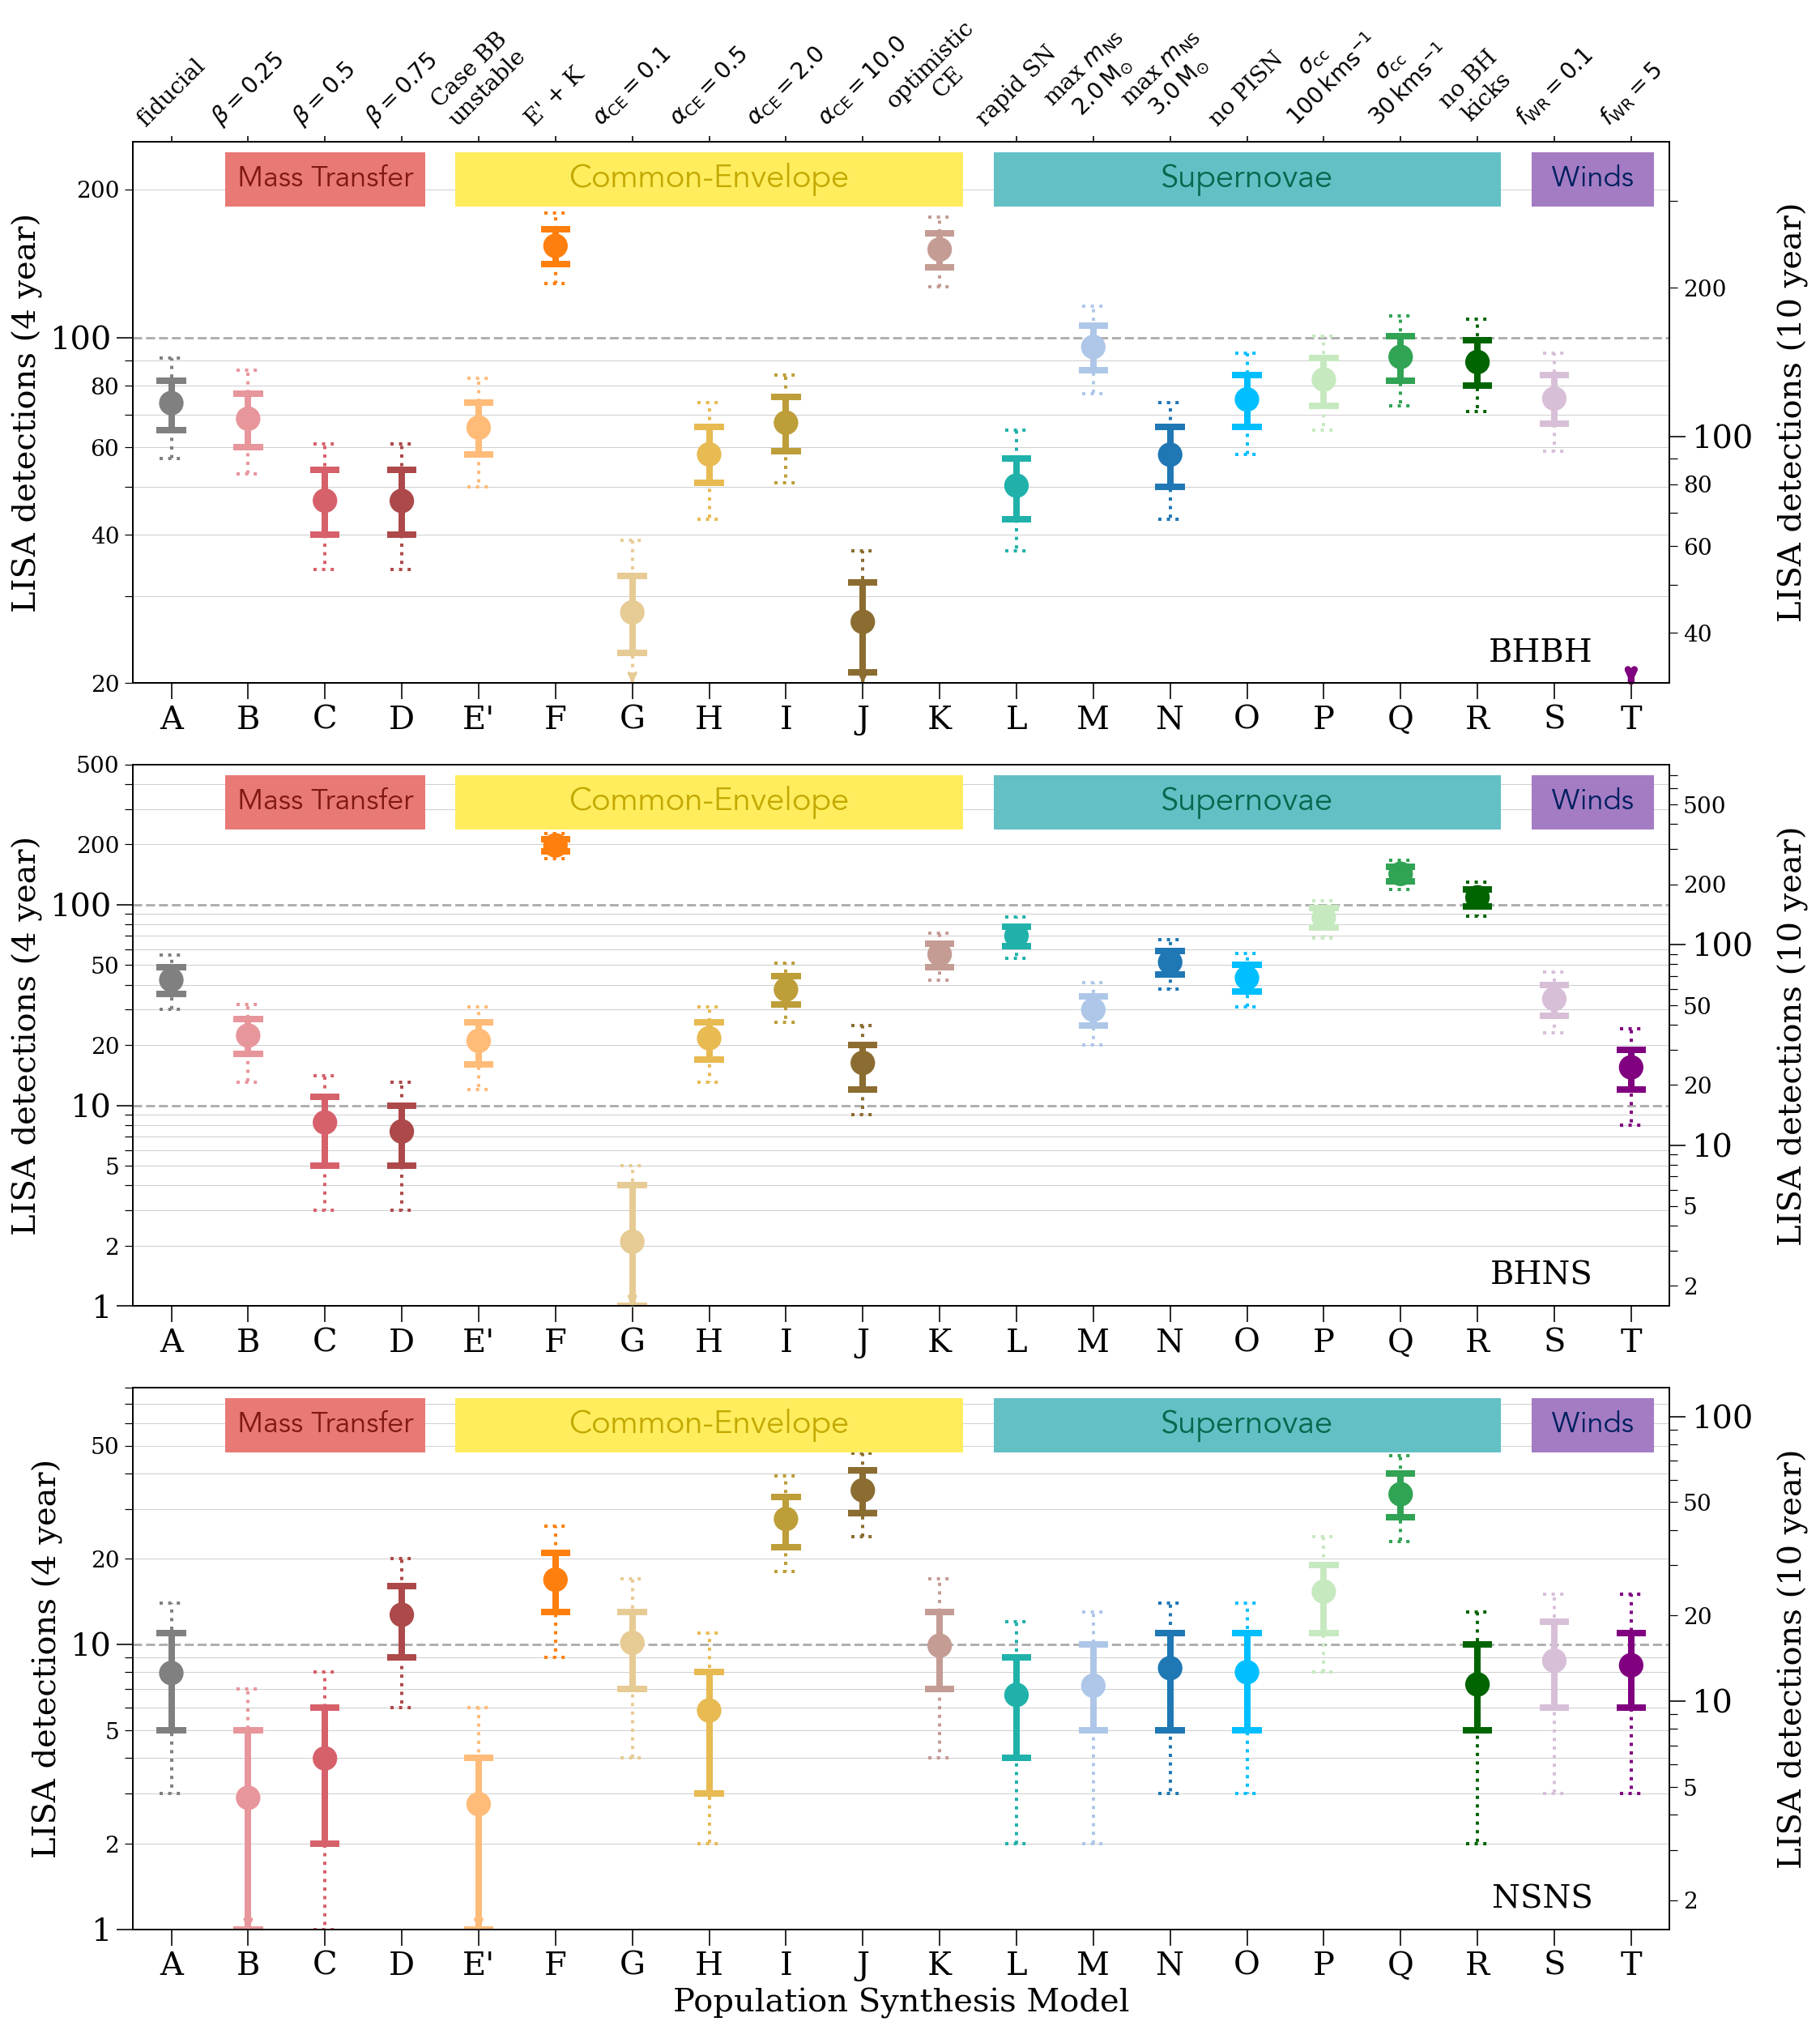

In [6]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

limits = {
    "BHBH": (2e1, 2.5e2),
    "BHNS": (1e0, 5e2),
    "NSNS": (1e0, 8e1)
}

tick_locs = {
    "BHBH": [2, 4, 6, 8],
    "BHNS": [2, 5],
    "NSNS": [2, 5],
}

# plot a panel for each DCO type and make the axes readable
for ax, dco_type in zip(axes, dco_types):
    plot_variations(label=dco_type, variations=variations,
                    means=np.mean(detections_4yr, axis=2)[dco_types.index(dco_type)],
                    xlabel=None, ylabel="LISA detections (4 year)",
                    fig=fig, ax=ax, show=False, yscale="log", limit=limits[dco_type])
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("log")
    right_ax.set_ylabel("LISA detections (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
    for axis in [ax, right_ax]:
        axis.yaxis.set_major_formatter(ScalarFormatter())
        axis.yaxis.set_minor_formatter(ScalarFormatter())

        minor_ticks, major_ticks, labels = get_log_ticks(axis.get_ylim()[0], axis.get_ylim()[1], tick_locs=tick_locs[dco_type])
        axis.set_yticks(major_ticks)
        axis.set_yticks(minor_ticks, minor=True)
        axis.set_yticklabels(labels, minor=True)
        axis.tick_params(axis="y", which="minor", labelsize=0.7*fs)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../figures/fig8_dco_detections.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

# Relative detection rate plot
Alternatively we can plot the detection rate relative to the fiducial model

In [7]:
def plot_relative_variations(dco_type, variations, detections,
                             dotsize=50, xlabel=None, ylabel=r"$\mathcal{R}_{\rm variation} / \mathcal{R}_{\rm fiducial}$",
                             yscale="log", fig=None, ax=None, show=True, limit=(1e-2, 1e2)):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    means = np.mean(detections, axis=2)[dco_types.index(dco_type)]
    
    one_sig = [scipy.stats.poisson(means).ppf(0.5 - (0.6827 / 2)),
               scipy.stats.poisson(means).ppf(0.5 + (0.6827 / 2))] / means[0]
    
    two_sig = [scipy.stats.poisson(means).ppf(0.5 - (0.9545 / 2)),
               scipy.stats.poisson(means).ppf(0.5 + (0.9545 / 2))] / means[0]
    
    means /= means[0]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
        
    ax.fill_between(xticks, one_sig[0], one_sig[1], color=dco_colours[dco_type], zorder=4, lw=2, alpha=0.3)
    
    ax.plot(xticks, means, color=dco_colours[dco_type], zorder=4, lw=2)
    ax.scatter(xticks, means, s=dotsize, color=dco_colours[dco_type], zorder=5)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    offset = 0.3
    for lower, upper, color, label, lc, lfs in [(1, 3, "#db2b25", "Mass Transfer", "#801814", 0.9*fs), (4, 10, "#FFE300", "Common-Envelope", "#C3A900", fs),
                                       (11, 17, "#089CA3", "Supernovae", "#08684E", fs), (18, 19, "#7030A0", "Winds", "#002060", 0.9*fs)]:
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color="white", linewidth=0, zorder=10)
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color=color, alpha=0.63, linewidth=0, zorder=11)
        ax.annotate(label, xy=(((upper - lower) / 2 + 0.5 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color=lc, fontsize=lfs, fontname="Avenir", zorder=12)
    
    ax.set_ylim(limit)
    
    if show:
        plt.show()
    return fig, ax

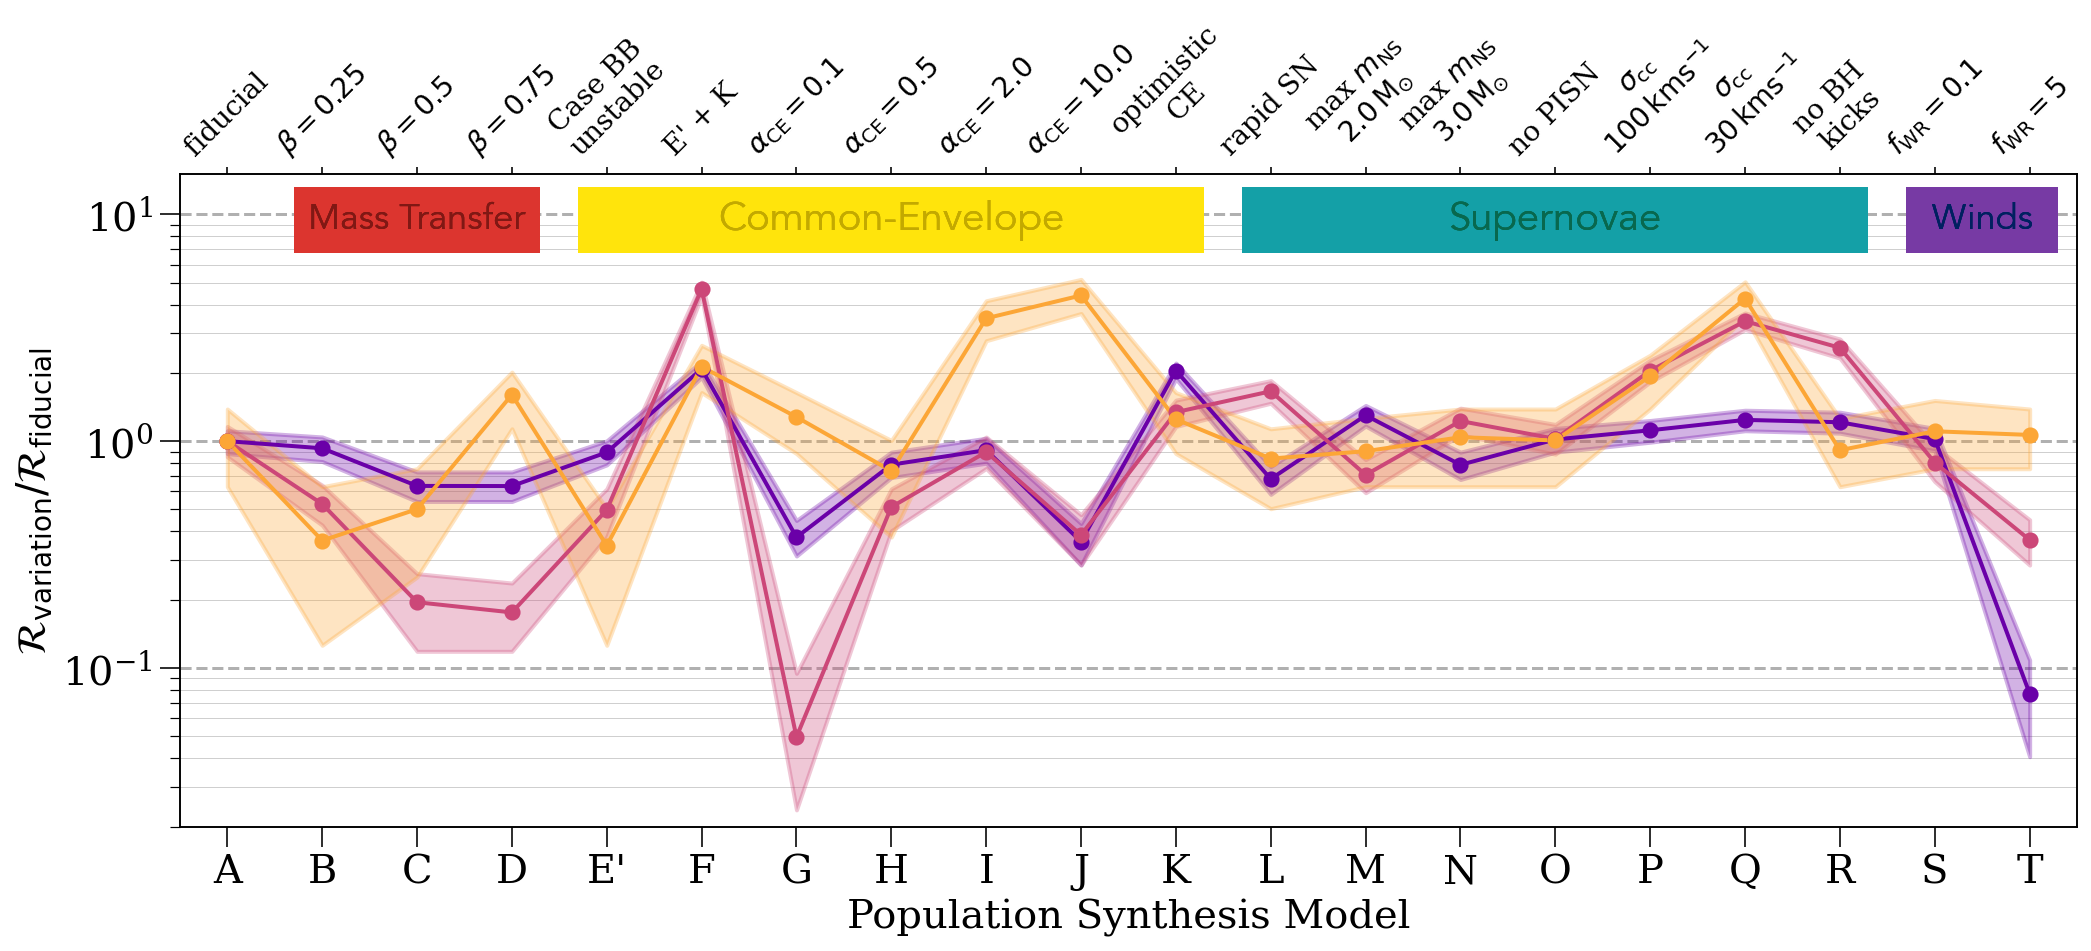

In [8]:
fig, ax = plt.subplots(1, figsize=(17, 6))
fig.subplots_adjust(hspace=0.15)

for dco_type in dco_types:
    plot_relative_variations(dco_type, variations, detections_4yr,
                             fig=fig, ax=ax, show=False, yscale="log", limit=(2e-2, 1.5e1))
    
top_ax = ax.twiny()
top_ax.set_xticks(ax.get_xticks())
top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

ax.set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../figures/extra_figures/dco_relative_rates.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

# Detection rate table (Table 3)
This code creates the latex necessary to make a table of the detection rates

In [9]:
minmaxes = np.concatenate((detections_4yr.mean(axis=2).min(axis=1),
                           detections_4yr.mean(axis=2).max(axis=1),
                           detections_10yr.mean(axis=2).max(axis=1),
                           detections_10yr.mean(axis=2).max(axis=1),
                           [detections_4yr.mean(axis=2).sum(axis=0).min()],
                           [detections_4yr.mean(axis=2).sum(axis=0).max()],
                           [detections_10yr.mean(axis=2).sum(axis=0).min()],
                           [detections_10yr.mean(axis=2).sum(axis=0).max()]))

In [10]:
def add_table_col(mean, superscript=None, include_superscipts=False, nobold=False):
    low, high = scipy.stats.poisson(mean).ppf(0.5 - (0.6827 / 2)),\
                scipy.stats.poisson(mean).ppf(0.5 + (0.6827 / 2)),    
    lower = mean - low
    upper = high - mean

    if superscript is not None and include_superscipts:
        return r" & $^{\rm " + superscript + "}$ \confinv{" + "{:.0f}".format(mean) + "}{" \
            + "{:.0f}".format(lower) + "}{" \
            + "{:.0f}".format(upper) + "}"
    elif mean in minmaxes and not nobold:
        return r" & \boldconfinv{" + "{:.0f}".format(mean) + "}{" \
            + "{:.0f}".format(lower) + "}{" \
            + "{:.0f}".format(upper) + "}"
    else:
        return r" & \confinv{" + "{:.0f}".format(mean) + "}{" \
            + "{:.0f}".format(lower) + "}{" \
            + "{:.0f}".format(upper) + "}"

In [11]:
table = ""
for i in range(len(variations)):
    table_line = variations[i]["short"] + " & " + variations[i]["long"]
    for detection in [detections_4yr, detections_10yr]:
        table_line += add_table_col(detection[:, i].mean(axis=1).sum())
        for j in range(len(detection)):
            table_line += add_table_col(np.mean(detection[j][i]))
    table_line += "\\\\"
    table += table_line + "\n"    

table += "\hline \n"
minimum_line = "- & Minimum rate"
maximum_line = "- & Maximum rate"
for detection in [detections_4yr, detections_10yr]:
    minimum_line += add_table_col(detection.mean(axis=2).sum(axis=0).min(), nobold=True,
                                  superscript=variations[detection.mean(axis=2).sum(axis=0).argmin()]["short"])
    maximum_line += add_table_col(detection.mean(axis=2).sum(axis=0).max(), nobold=True,
                                  superscript=variations[detection.mean(axis=2).sum(axis=0).argmax()]["short"])
    for j in range(len(detection)):
        minimum_line += add_table_col(detection.mean(axis=2).min(axis=1)[j], nobold=True,
                                      superscript=variations[detection.mean(axis=2).argmin(axis=1)[j]]["short"])
        maximum_line += add_table_col(detection.mean(axis=2).max(axis=1)[j], nobold=True,
                                      superscript=variations[detection.mean(axis=2).argmax(axis=1)[j]]["short"])

table += minimum_line + " \\\\\n"
table += maximum_line + " \\\\\n"
        
print(table)

A & Fiducial & \confinv{124}{11}{11} & \confinv{74}{9}{8} & \confinv{42}{6}{7} & \confinv{8}{3}{3} & \confinv{202}{15}{14} & \confinv{117}{10}{11} & \confinv{71}{8}{8} & \confinv{13}{4}{4}\\
B & Fixed mass transfer efficiency of $\beta=0.25$ & \confinv{94}{10}{10} & \confinv{69}{9}{8} & \confinv{22}{4}{5} & \confinv{3}{2}{2} & \confinv{149}{12}{12} & \confinv{108}{11}{10} & \confinv{37}{6}{6} & \confinv{5}{2}{2}\\
C & Fixed mass transfer efficiency of $\beta=0.5$ & \confinv{59}{8}{8} & \confinv{47}{7}{7} & \confinv{8}{3}{3} & \confinv{4}{2}{2} & \confinv{96}{10}{9} & \confinv{76}{9}{8} & \confinv{14}{4}{3} & \confinv{7}{3}{2}\\
D & Fixed mass transfer efficiency of $\beta=0.75$ & \confinv{67}{8}{8} & \confinv{47}{7}{7} & \confinv{7}{2}{3} & \confinv{13}{4}{3} & \confinv{104}{10}{11} & \confinv{71}{8}{8} & \confinv{12}{3}{4} & \confinv{21}{4}{5}\\
E' & Case BB mass transfer is always unstable & \confinv{90}{10}{9} & \confinv{66}{8}{8} & \confinv{21}{5}{5} & \boldconfinv{3}{2}{1} & \conf